In [1]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools
from torch.utils.tensorboard import SummaryWriter

In [2]:
# if torch.cuda.is_available():  
#     device = "cuda:0" 
# else:  
#     device = "cpu" 
    
# torch.cuda.current_device()

In [2]:
# Code from Maastricht to access GPU of choice

import torch
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [3]:
torch.cuda.set_device(0)
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')


In [4]:
torch.cuda.current_device(), torch.cuda.get_device_name()

(0, 'GeForce GTX 1080 Ti')

## Import data

In [5]:
traindatadir = '\\\\tsclient\\E\\Preprocessed\\TrainCalcClusterReal'
testdatadir = '\\\\tsclient\\E\\Preprocessed\\TestCalcClusterReal'
savedir = '\\\\tsclient\\E\\Models'

In [14]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode


# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, annotations_file, img_dir, mask_dir, transform=None, target_transform=None):
        # Read the .csv file with all the information
        self.img_labels = pd.read_csv(os.path.join(root, annotations_file))
        # Define the directories of the images and masks
        self.img_dir = os.path.join(root, img_dir)
        self.mask_dir = os.path.join(root, mask_dir)
        # Define whethet transformations are included
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Read the image and the mask for a case from the directories
        img_path = self.img_labels.iloc[idx, 0]
        mask_path = self.img_labels.iloc[idx,6]
        img_path = img_path.replace('E:', '\\\\tsclient\E')
        mask_path = mask_path.replace('E:', '\\\\tsclient\E')
        image = read_image(img_path).float()
        mask = read_image(mask_path)

        # Resize so all images and masks have the same size
#         image = T.Resize([800,800])(image)
#         mask = T.Resize([800,800])(mask)    
#         resize_scale_x = 800/image.size()[1]
#         resize_scale_y = 800/image.size()[2]

        # Resize if necessary
        # First the smallest dimension is reduced to 400 if it is larger
        # Then the largest dimension is reduced to 650 if it is still larger
        resize_scale = 1.0
        min_size_idx = np.argmin([image.size()[1], image.size()[2]])
        
        if min_size_idx == 0 and image.size()[1] > 400 :
            resize_scale *= 400/image.size()[1]
            image = T.Resize([400, int(400*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([400, int(400*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 0 and image.size()[2] > 650 :
            resize_scale *= 650/image.size()[2]
            image = T.Resize([int(650*image.size()[1]/image.size()[2]), 650])(image)
            mask = T.Resize([int(650*image.size()[1]/image.size()[2]), 650], interpolation=InterpolationMode.NEAREST)(mask)
        
        if min_size_idx == 1 and image.size()[2] > 400 :
            resize_scale *= 400/image.size()[2]
            image = T.Resize([int(400*image.size()[1]/image.size()[2]), 400])(image)
            mask = T.Resize([int(400*image.size()[1]/image.size()[2]), 400], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 1 and image.size()[1] > 650 :
            resize_scale *= 650/image.size()[1]
            image = T.Resize([650, int(650*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([650, int(650*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
            
        # Normalize image with mean and standard deviation per channel
        mean = torch.mean(image, dim=(1,2))
        stdev = torch.std(image, dim=(1,2))
        image = T.Normalize(mean, stdev)(image)
        
        # Rescale to [0,1] range per channel
        for dim in range(3) :
            image[dim] -= torch.min(image[dim])
            image[dim] /= torch.max(image[dim])  
        
        # Create separate channel in mask for each lesion
        mask_out = np.zeros((torch.max(mask).item(), mask.shape[-2], mask.shape[-1]))
        for lesion_idx in range(torch.max(mask).item()) :
            mask_out[lesion_idx][mask[0]==lesion_idx+1] = 1      
        
        # Read the location of the lesion bounding box from the .csv file
        xmin = self.img_labels.iloc[idx, 1]
        xmax = self.img_labels.iloc[idx, 2]
        ymin = self.img_labels.iloc[idx, 3]
        ymax = self.img_labels.iloc[idx, 4]
        boxes = [[ymin*resize_scale, xmin*resize_scale, ymax*resize_scale, xmax*resize_scale]]
        # Read the label of the lesion from the .csv file
        labels = self.img_labels.iloc[idx, 5]  
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        labels = torch.tensor([labels])
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        mask_out = torch.from_numpy(mask_out)
        mask_out = mask_out.to(torch.uint8)
        
        iscrowd = torch.zeros((2,), dtype=torch.int64)
        
        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)  
            
        target = {}
        target["image_id"] = image_id
        target["masks"] = mask_out
        target["boxes"] = boxes
        target["area"] = area
        target["labels"] = labels
        target["iscrowd"] = iscrowd
            
        return image, target


In [15]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import utils
from torch.utils.data import random_split

# Read training dataset and split in training and validation data
trainval_data = CustomImageDataset(traindatadir, 'annotations_train_calccluster_real_smallset.csv', 'colored_to_jpg', 'mask_to_png')
train_data, val_data = random_split(trainval_data, [int(np.floor(len(trainval_data)*0.8)), int(np.ceil(len(trainval_data)*0.2))], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)

# Read test dataset
test_data = CustomImageDataset(testdatadir, 'annotations_test_calccluster_real.csv', 'colored_to_jpg', 'mask_to_png')
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [16]:
# For Training
train_images, train_targets = next(iter(train_dataloader))
train_image_list = list(image for image in train_images)
train_target_list = [{k: v for k, v in t.items()} for t in train_targets]

# For Validation
val_images, val_targets = next(iter(val_dataloader))
val_image_list = list(image for image in val_images)
val_target_list = [{k: v for k, v in t.items()} for t in val_targets]

# For Testing
test_images, test_targets = next(iter(test_dataloader))
test_image_list = list(image for image in test_images)
test_target_list = [{k: v for k, v in t.items()} for t in test_targets]

In [17]:
for t in train_targets :
    for k,v in t.items() :
        print(k,v)
        v.to(device)


image_id tensor([6])
masks tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
boxes tensor([[158.5462, 389.3159, 205.4483, 427.8734]])
area tensor([1808.4277])
labels tensor([1])
iscrowd tensor([0, 0])
image_id tensor([16])
masks tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
boxes tensor([[176.7393, 303.5537, 200.7673, 324.1110]])
area tensor([493.9503])
labels tensor([0])
iscro

In [18]:
val_target_list

[{'image_id': tensor([4]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[ 72.4963, 237.0418, 182.8952, 417.2297]]),
  'area': tensor([19892.5488]),
  'labels': tensor([0]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([15]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tens

In [19]:
test_target_list

[{'image_id': tensor([90]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[ 43.0200, 223.0246, 207.8544, 403.2556]]),
  'area': tensor([29708.2734]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([81]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0,

In [20]:
train_targets[0]['image_id'], train_targets[1]['image_id'], train_targets[2]['image_id'], train_targets[3]['image_id']

(tensor([6]), tensor([16]), tensor([0]), tensor([5]))

tensor([16]) tensor([[176.7393, 303.5537, 200.7673, 324.1110]])
[253, 374, 126, 250]


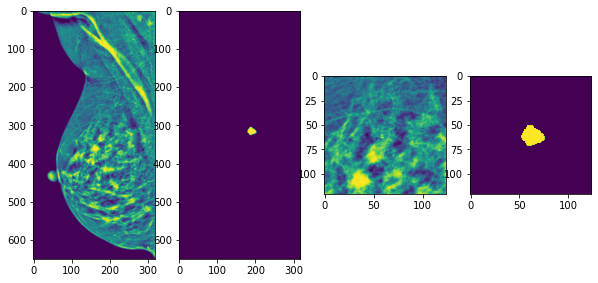

In [21]:
pat_idx = 1
print(train_targets[pat_idx]['image_id'], train_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(train_images[pat_idx][0])
ax[1].imshow(train_targets[pat_idx]['masks'][0])

enlarged_box = [int(train_targets[pat_idx]['boxes'][0][1])-50,
                int(train_targets[pat_idx]['boxes'][0][3])+50,
                int(train_targets[pat_idx]['boxes'][0][0])-50,                
                int(train_targets[pat_idx]['boxes'][0][2])+50]
print(enlarged_box)
ax[2].imshow(train_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(train_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

## Define model

In [22]:
import torchvision
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# backbone = torchvision.models.resnet101(pretrained=True, progress=True)
# backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=3,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=3,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler,
                 min_size=400,
                 max_size=650)

# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

In [23]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=650, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
   

In [24]:
def train_one_epoch_kulum(model, optimizer, data_loader, writer, device, epoch, print_freq, scaler=None):
    
    # Initialise training
    model.train()
    
    # Set up logger to save metrics and losses
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    # Define scheduler for learning rate in optimizer
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Read the images and targets from the data loader
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
           
        # Write to .tfevents
#         grid = torchvision.utils.make_grid(images)
#         writer.add_image('images', grid, 0)
#         writer.add_graph(model, images)
        
        writer.add_scalar('Loss/train', metric_logger.loss.value, epoch)
        writer.add_scalar('Loss classifier/train', metric_logger.loss_classifier.value, epoch)

    return metric_logger

In [25]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

model_writer = SummaryWriter('\\\\tsclient\\E\\runs\smallexp')

# let's train it for 10 epochs
num_epochs = 200
logs = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
#     sample_image, sample_target = sample(next(iter(train_dataloader)))
    
#     sample_image, sample_target = first(train_dataloader)
#     output = self.model(sample_image.to(self.device))
    
    epoch_loss = train_one_epoch_kulum(model, optimizer, train_dataloader, model_writer, device, epoch, print_freq=10)
#     epoch_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    logs.append(epoch_loss)
    
    # update the learning rate
#     lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dataloader, device=device)
    
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 'loss_classifier': loss_classifier,
#                 'loss_box_reg': loss_box_reg,
#                 'loss_mask': loss_mask,
#                 'loss_objectness': loss_objectness,
#                 'loss_rpn_box': loss_rpn_box
#                 }, savedir)
    
    if epoch % 5 == 0 :
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, os.path.join(savedir, 'model_small200_'+str(epoch)+'.pth'))
        
model_writer.close()

C:\Users\P70074720\.conda\envs\pytorch36\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [0/5]  eta: 0:01:32  lr: 0.001254  loss: 6.0518 (6.0518)  loss_classifier: 1.1397 (1.1397)  loss_box_reg: 0.0001 (0.0001)  loss_mask: 4.2285 (4.2285)  loss_objectness: 0.6788 (0.6788)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 18.5651  data: 8.6262  max mem: 3046
Epoch: [0]  [4/5]  eta: 0:00:10  lr: 0.005000  loss: 1.4731 (3.2746)  loss_classifier: 0.7929 (0.6896)  loss_box_reg: 0.0002 (0.0021)  loss_mask: 0.0190 (1.9412)  loss_objectness: 0.6559 (0.6372)  loss_rpn_box_reg: 0.0047 (0.0045)  time: 10.8387  data: 8.4763  max mem: 3969
Epoch: [0] Total time: 0:00:54 (10.8794 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:15  model_time: 0.1875 (0.1875)  evaluator_time: 0.0000 (0.0000)  time: 7.8136  data: 7.5948  max mem: 3969
Test:  [1/2]  eta: 0:00:04  model_time: 0.0782 (0.1328)  evaluator_time: 0.0000 (0.0000)  time: 4.8679  data: 4.7194  max mem: 3969
Test: Total time: 0:00:09 (4.8757 s / it)
Averaged stats: model_time: 0.0782 (0.1328)  evaluator_time: 0.

In [47]:
torch.save(model.state_dict(), os.path.join(savedir, 'dict.dict'))
torch.save(model, os.path.join(savedir, 'model50_final.pth'))

In [41]:
train_images_cuda = []
for te in train_images :
    train_images_cuda.append(te.to(device))
    

In [49]:
# test_images.to(device)
predictions = model(train_images_cuda)

In [52]:
logs[0].loss.value

losses = []
losses_class = []
losses_box_reg = []
losses_mask = []
losses_objectness = []
losses_rpn_box_reg = []
for ep in range(len(logs)) :
    losses.append(logs[ep].loss.value)
    losses_class.append(logs[ep].loss_classifier.value)
    losses_box_reg.append(logs[ep].loss_box_reg.value)
    losses_mask.append(logs[ep].loss_mask.value)
    losses_objectness.append(logs[ep].loss_objectness.value)
    losses_rpn_box_reg.append(logs[ep].loss_rpn_box_reg.value)

Text(0.5, 1.0, 'Loss_rpn_box_reg')

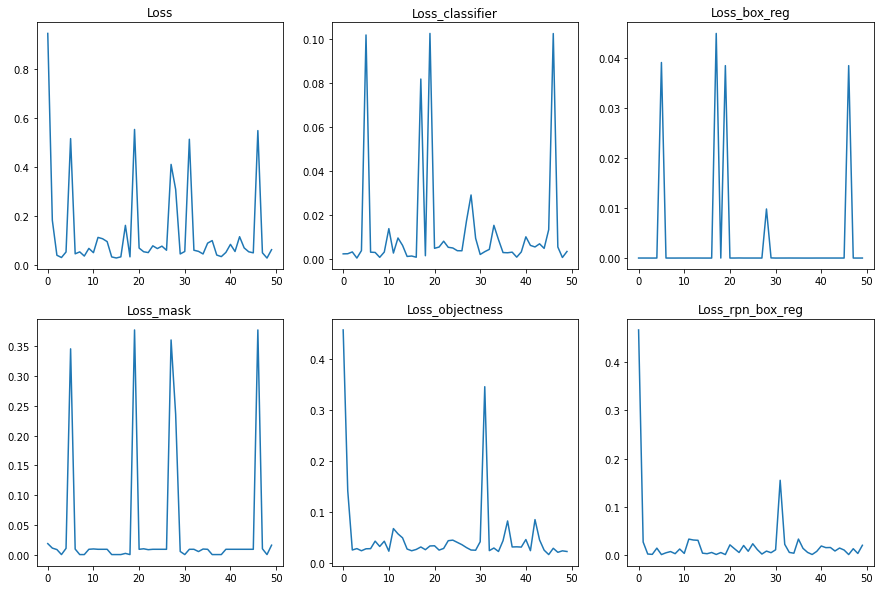

In [53]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].plot(range(len(logs)),losses)
ax[0,0].set_title('Loss')
ax[0,1].plot(range(len(logs)),losses_class)
ax[0,1].set_title('Loss_classifier')
ax[0,2].plot(range(len(logs)),losses_box_reg)
ax[0,2].set_title('Loss_box_reg')
ax[1,0].plot(range(len(logs)),losses_mask)
ax[1,0].set_title('Loss_mask')
ax[1,1].plot(range(len(logs)),losses_objectness)
ax[1,1].set_title('Loss_objectness')
ax[1,2].plot(range(len(logs)),losses_rpn_box_reg)
ax[1,2].set_title('Loss_rpn_box_reg')

In [52]:
torch.max(predictions[2]['masks'])

tensor(0.0048, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             ...
#             }, PATH)

In [33]:
model = model.cpu()

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (lesion) + background
num_classes = 3  # 2 classes (lesion benign + lesion malignant) + background


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
predictions

[{'boxes': tensor([[2.5803e+02, 2.3219e+02, 3.9800e+02, 2.9883e+02],
          [1.1064e+02, 1.4831e+02, 1.4184e+02, 1.6377e+02],
          [1.0749e+02, 1.3834e+02, 1.3233e+02, 1.7288e+02],
          [1.5622e+02, 1.9665e+02, 1.8711e+02, 2.1219e+02],
          [1.6788e+02, 1.8433e+02, 1.9201e+02, 2.2053e+02],
          [1.1911e+02, 1.3744e+02, 1.4418e+02, 1.7179e+02],
          [1.7898e+02, 1.8363e+02, 2.0447e+02, 2.1935e+02],
          [1.6970e+02, 1.9679e+02, 2.0021e+02, 2.1216e+02],
          [1.6757e+02, 1.7333e+02, 1.9111e+02, 2.0816e+02],
          [1.5799e+02, 1.8500e+02, 1.8792e+02, 2.0049e+02],
          [1.3170e+02, 1.3631e+02, 1.5699e+02, 1.7156e+02],
          [1.7809e+02, 2.9156e+02, 2.2092e+02, 3.0000e+02],
          [1.3280e+02, 1.4856e+02, 1.6463e+02, 1.6433e+02],
          [1.5361e+02, 2.9105e+02, 1.9505e+02, 3.0000e+02],
          [1.9327e+02, 1.7342e+02, 2.2308e+02, 1.8913e+02],
          [1.8191e+02, 1.9727e+02, 2.1213e+02, 2.1275e+02],
          [1.9056e+02, 1.0140e+

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
import utils as vision_utils

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
output = model(image_list, target_list)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
predictions = model(x)           # Returns predictions

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [14]:
output

{'loss_classifier': tensor(0.0169, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0004, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(11.8512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(35.1903, grad_fn=<DivBackward0>)}